## 01. Preliminary simulation of spectra for 10 stars using Slitless-Spectroscopy

This notebook uses the spectral library [Phoenix](http://phoenix.astro.physik.uni-goettingen.de/) to study the synthetic spectra from stars of different spectra types. Ten stars of different effective temperature $T_e$ and surface gravity $g$ are chosen, and their spectra is plotted. Furthermore, this notebook attempts to recover the spectral image one would obtain when observing these stars in the slitless spectroscopy mode.

The notebook is divided into the following sections:

1. Defining the input parameters
2. Spectral parameters
3. Opening and reading the file
4. Plotting the spectra
5. Forming a spectral image
6. Adding noise, LSF, and PSF

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine Neumayer and Francisco Nogueras-Lara (MPIA)** <br/>
Date: **18th September 2020** <br/>

In [1]:
import astropy.units as u
import astropy.io.fits as fits

from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

# to show progress during computations
from time import sleep
import sys

import matplotlib

# for manupilating spectra
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from specutils import Spectrum1D

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt

#### 1. Defining the input parameters

In [4]:
# array containing the wavelength values for all the spectra
wave_filename = 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

# number of stars and generating their random positions
num_stars = 10
l_pix, u_pix = 0, 2000
x_pos = ss.generateRandInt(l_pix, u_pix, num_stars) 
y_pos = ss.generateRandInt(l_pix, u_pix, num_stars)

# corresponsing resolution
r = 1000

# wavelength to pixel conversions
delta_lambda = 0.001  # micro meter ==  1 pixel
k_band_lambda0 = 2.2
r = k_band_lambda0/delta_lambda

k_band_range = 0.6 # micro meter
disperse_range = k_band_range/delta_lambda 
print('The spectra is dispersed over %d pixels'%disperse_range)

dispersion_angle = 0 # degrees

# number of spectra
num_spectra = num_stars

# parameters considered :: [t_eff, log_g, Fe_H, alpha, spectral_types]
num_params = 5

# limits for for k-band range
k_upper, k_lower = 2.4e4, 2.1e4 # units are in angstrom

The spectra is dispersed over 600 pixels


#### 2. Spectral parameters

In [5]:
# [K] effective temperature
t_eff_arr = [12000, 11800, 10000, 8400, 7600, 6900, 5900, 5100, 4700, 3900]    

# log of [cm/s^2] log (surface gravity) 
log_g_arr = [6.00, 2.50, 3.00, 6.00, 3.50, 3.00, 3.00, 2.00, 1.50, 6.00]    

# [M/H] metallicity
Fe_H = 0.0      

# [a/M] alpha element enhancement
alpha = 0       

spectral_type = ss.defineSpectralType(HiRes=True, MedRes=False)

Parameters for adding noise, LSF and PSF

In [6]:
# define the level of white noise to add to the system (in %)
noise_level = 5

# deviation set for LSF, PSF 
sigma_LSF = 10
sigma_PSF = 10

# defining the pixel-spread in the x-y direction i.e. dispersion_range/factor_widen 
# usint: pixels, note that higher the value of the factor, lower is the spread
factor_widen_PSF = 1

#### 3. Opening and reading the file

The following code blocks puts together the fluxes and wavelegnths for all the chosen spectra into a 2D array.

In [7]:
_, len_wavelen = ss.extractWavelen(data_dir, wave_filename)
wave_len_arr2D, flux_arr2D = np.empty((0, len_wavelen)), np.empty((0, len_wavelen))
params_arr2D = np.empty((0, num_params)) 

for i in range(num_spectra):
    # choose the t_eff and log_g
    t_eff, log_g = t_eff_arr[i], log_g_arr[i]
    params = [t_eff, log_g, Fe_H, alpha, spectral_type]

    # read out the wavelength and flux for given set of parameters
    wave_len, flux = ss.readFile(data_dir, wave_filename, params)

    # add the wavelength and flux values to the 2D arrays
    wave_len_arr2D = np.append(wave_len_arr2D, [wave_len], axis=0)
    flux_arr2D = np.append(flux_arr2D, [flux], axis=0)
    params_arr2D = np.append(params_arr2D, [params], axis=0)

#### 4. Plotting the spectra

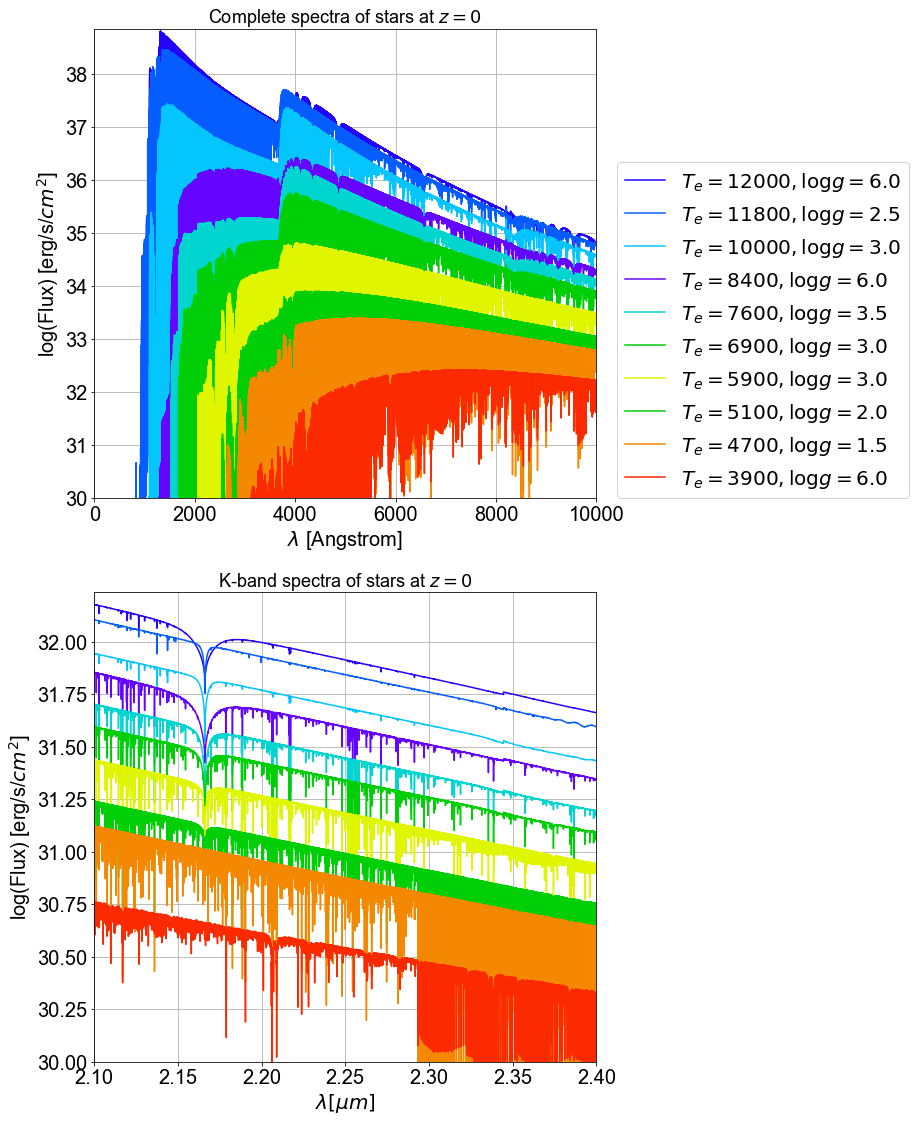

In [56]:
fig,ax = plt.subplots(2,1,figsize=(9,19))
colors = ['#2403fc', '#055dff', '#05c5ff', '#6505ff', '#02d4d0', '#00cf07', '#e0f500', '#00cf07', '#f58802', '#fc2a00']

for i in range(num_spectra):    
    # complete spectra
    ax[0].plot(wave_len_arr2D[i], np.log(flux_arr2D[i]), color=colors[i], \
               label=pt.labelSpectra(params_arr2D[i]));
    pt.setLabel(ax[0], r'$\lambda$ [Angstrom]', r'log(Flux) [erg/s/$cm^2$]', \
                r'Complete spectra of stars at $z=0$', [0, 1e4], [30, np.log(7.5e16)],\
                legend=True)

    # k-band spectra (flux is log)
    ax[1].plot(wave_len_arr2D[i]/10000, np.log(flux_arr2D[i]), color=colors[i])
    pt.setLabel(ax[1], r'$\lambda [\mu m]$', r'log(Flux) [erg/s/$cm^2$]', r'K-band spectra of stars at $z=0$', [2.1, 2.4], [30, np.log(1e14)], legend=False)

#### 5. Forming a spectral image

We chose dispersions only in the K-band wavelengths for the stars. 

/usr/lib64/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


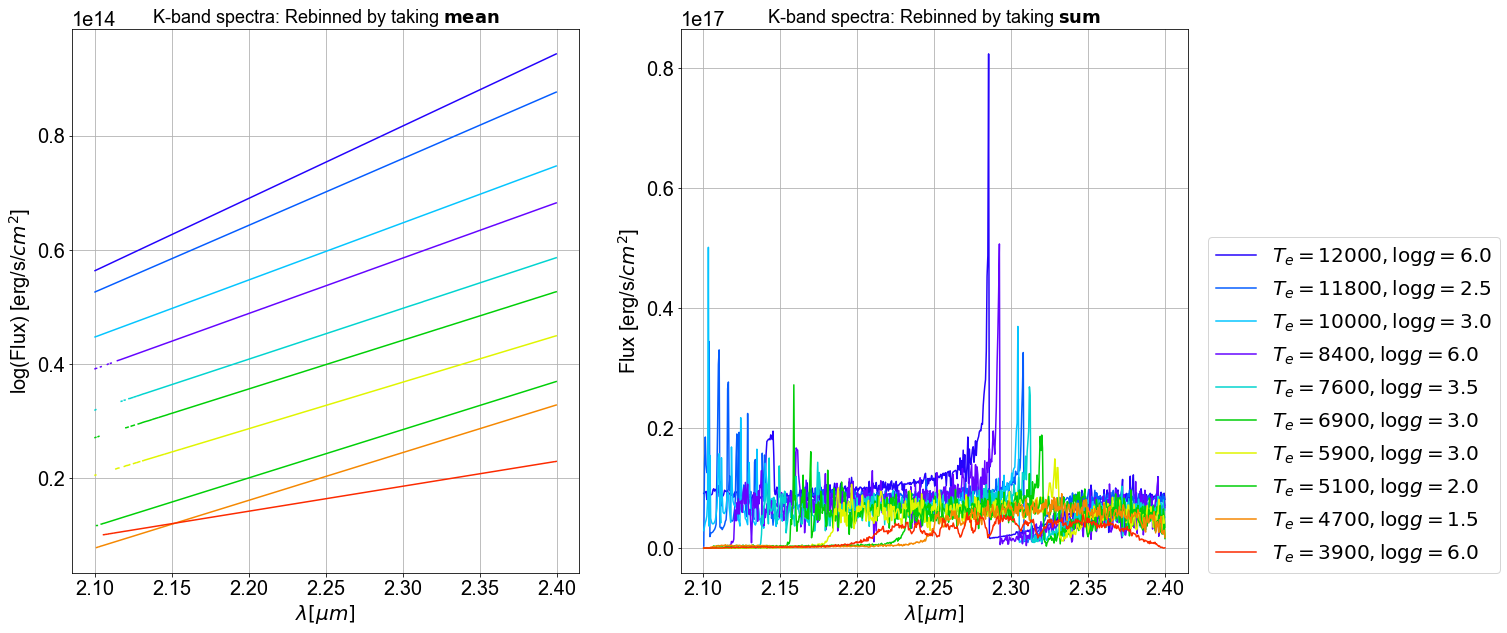

In [26]:
# chosing the K-band wavelength
waves_k, idx = ss.chooseKband(wave_len_arr2D, k_upper, k_lower, disperse_range)

# defining the K-band flux
flux_k2Dmean, flux_k2Dsum = np.empty((0, len(waves_k))), np.empty((0, len(waves_k)))
flux_k2Dmean = ss.fluxKband(flux_arr2D, x_pos, flux_k2Dmean, idx, disperse_range, 'mean')
flux_k2Dsum = ss.fluxKband(flux_arr2D, x_pos, flux_k2Dsum, idx, disperse_range, 'sum')

fig,ax = plt.subplots(1,2,figsize=(20,10))
for i in range(num_spectra):    
    # k-band spectra (flux rebinned by taking mean)
    ax[0].plot(waves_k, flux_k2Dmean[i], color=colors[i])
    pt.setLabel(ax[0], r'$\lambda [\mu m]$', r'log(Flux) [erg/s/$cm^2$]', \
                r'K-band spectra: Rebinned by taking $\mathbf{mean}$', 'default', 'default',\
                legend=False)
    
    # k-band spectra (flux rebinned by taking sum)
    ax[1].plot(waves_k, flux_k2Dsum[i], color=colors[i], label=pt.labelSpectra(params_arr2D[i]))
    pt.setLabel(ax[1], r'$\lambda [\mu m]$', r'Flux [erg/s/$cm^2$]', \
                r'K-band spectra: Rebinned by taking $\mathbf{sum}$', 'default', 'default',\
                legend=True)
    
    # define the flux
    flux_k2D[i] = flux_k2Dsum[i]/np.nanmax(flux_k2Dsum[i])

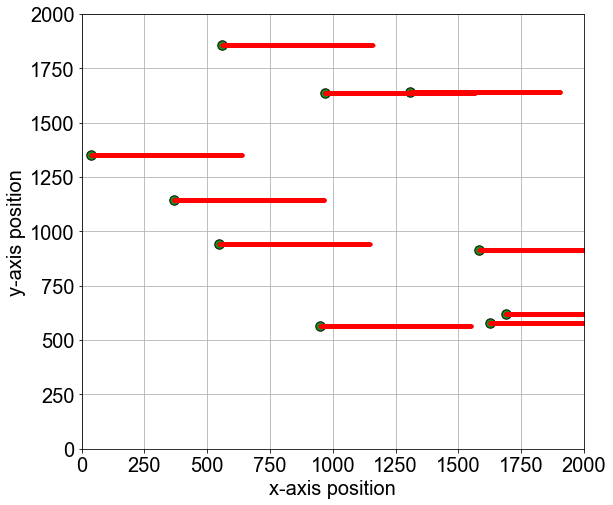

In [27]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

# plotting the stars
ax.scatter(x_pos, y_pos, s=90, c="g", alpha=0.9, marker="o", edgecolors='k')
pt.setLabel(ax, 'x-axis position', 'y-axis position', '', [l_pix, u_pix], \
            [l_pix, u_pix], legend=False)

# dispersing them in the k-band
x_disperse, y_disperse = ss.disperseStars(x_pos, y_pos, disperse_range, waves_k, ax, \
                                          dispersion_angle)

Producing a contour plot by adding the flux

In [74]:
flux_matrix2D = np.zeros((u_pix, u_pix))
flux_matrix2D = ss.construct2DFluxMatrix(flux_matrix2D, y_disperse, x_disperse,\
                                         flux_k2D, u_pix)

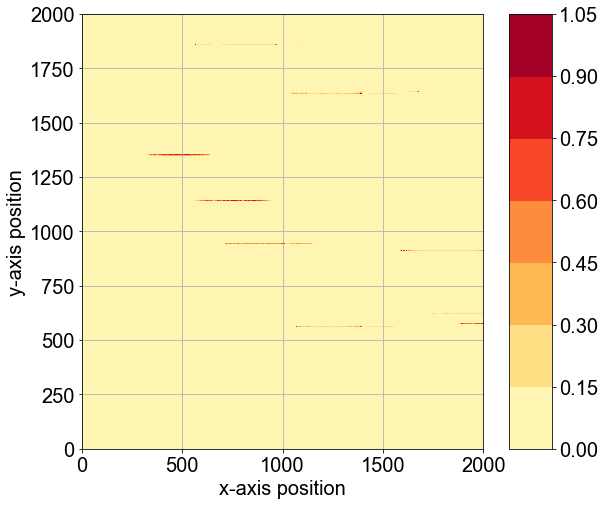

In [75]:
pt.plotContour(l_pix, u_pix, flux_matrix2D)

#### 6. Adding noise, the Point Spread Function (PSF) and Line Spread Function (LSF)

6.1. **Adding white noise** to the flux matrix

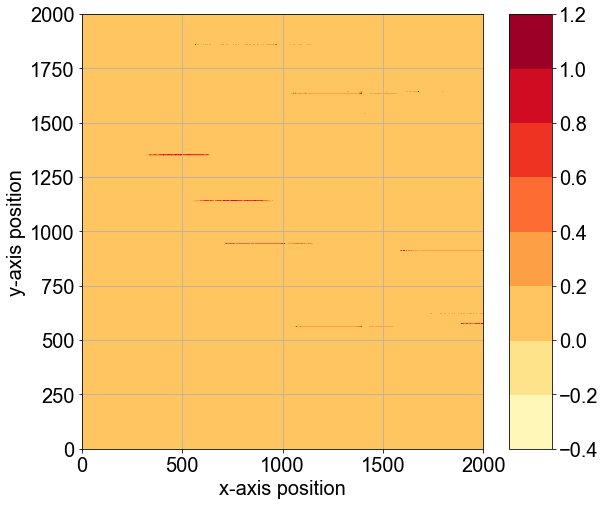

In [76]:
flux_noise_matrix2D = flux_matrix2D + ss.addNoise(noise_level, u_pix)
pt.plotContour(l_pix, u_pix, flux_noise_matrix2D)

6.2. **Adding LSF** to the flux matrix

Using [specutils](https://specutils.readthedocs.io/en/stable/) 

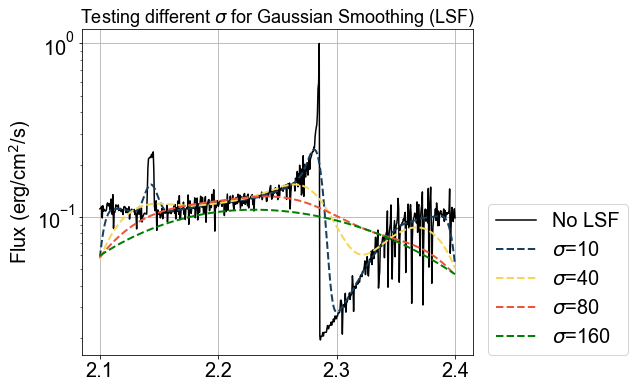

In [36]:
fig, ax = plt.subplots(1,1,figsize=(7, 6))
colors = ['#173F5F', '#F6D55C', '#ED553B', 'g']
sigma_LSF_arr = [10, 40, 80, 160]

pt.plotDifferentGaussianLSFs(ax, flux_k2D, waves_k, sigma_LSF_arr, \
                             colors, 'default', 'default')

[====================] 100%

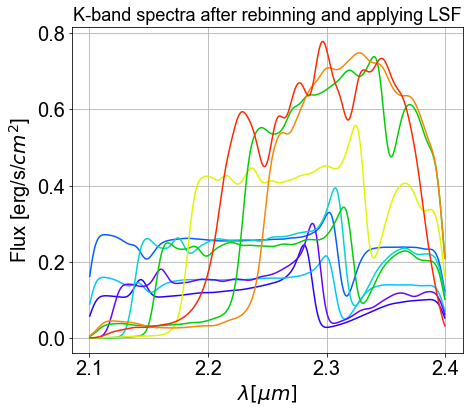

In [88]:
flux_LSF2D = ss.addLSF(x_pos, flux_k2D, sigma_LSF, waves_k)

fig, ax = plt.subplots(1,1,figsize=(7, 6))
for i in range(num_spectra):
    ax.plot(waves_k, flux_LSF2D[i], color=colors[i]) 
pt.setLabel(ax, r'$\lambda [\mu m]$', r'Flux [erg/s/$cm^2$]', \
            r'K-band spectra after rebinning and applying LSF', 'default',\
            'default', legend=False)

In [89]:
# save these spectra with lsf
np.save('Data/flux_K2D_LSF.npy', flux_LSF2D)
np.save('Data/params.npy', params_arr2D)
np.save('Data/waves_k.npy', waves_k)

Convert the 1D flux arrays into a 2D matrix for plotting the contour/density map

In [72]:
flux_LSF_matrix2D = np.zeros((u_pix, u_pix))
flux_LSF_matrix2D = ss.construct2DFluxMatrix(flux_LSF_matrix2D, y_disperse, \
                                             x_disperse, flux_LSF2D, u_pix)

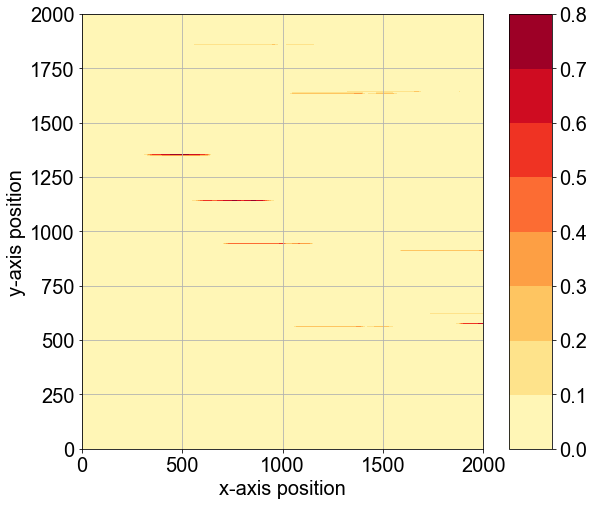

In [73]:
pt.plotContour(l_pix, u_pix, flux_LSF_matrix2D)

6.3. **Adding PSF** to the flux matrix

In [85]:
importlib.reload(ss)
flux_PSF3D, y_dispersePSF = ss.addPSF(y_pos, y_disperse, sigma_PSF, disperse_range, \
                                      factor_widen=factor_widen_PSF, norm=9)

flux_PSF_matrix2D = ss.constructFluxMatrixPSF(x_pos, x_disperse, y_dispersePSF, \
                                              flux_PSF3D, u_pix)

Adding PSF...

[====================] 100%

Creating 2D flux matrix...

[====================] 100%

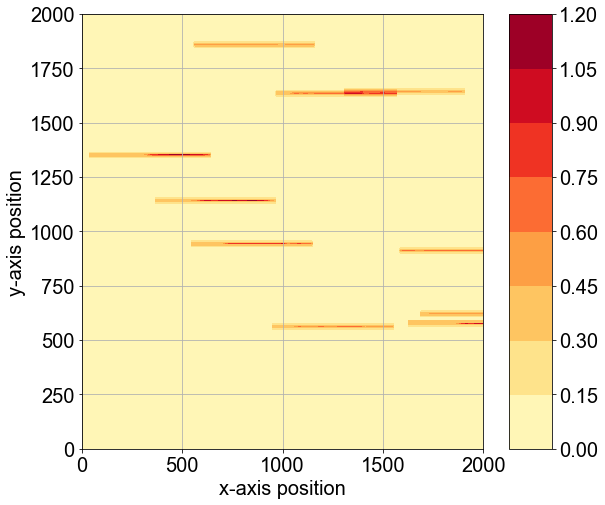

In [86]:
pt.plotContour(l_pix, u_pix, flux_PSF_matrix2D+flux_LSF_matrix2D)